# TF-IDF Keyword-Based Document Classification

This notebook uses TF-IDF to extract discriminative keywords for each document class,
then uses these keywords for classification.

## Approach:
- Extract top TF-IDF keywords per document class
- Build keyword signature for each class
- Classify by matching keyword signatures
- Use cosine similarity on TF-IDF vectors
- Local execution

## Advantages:
- Fast and interpretable
- Shows exact keywords that distinguish each class
- Works well for documents with specific terminology

## 1. Import Dependencies

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project root
project_root = Path().absolute().parent.parent
sys.path.insert(0, str(project_root))

# Data
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ML
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# GCS and MLflow
from gcs_bucket_interface import GCSBucketInterface
from mlflow_recorder import MLflowRecorder

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Environment
from dotenv import load_dotenv
load_dotenv()

print("All imports successful!")

All imports successful!


## 2. Configuration

In [2]:
EXPERIMENT_NAME = "tfidf_keywords_v1"
BUCKET_NAME = "gosexpert_categorize"
TRAIN_TEST_SPLIT = 0.3
RANDOM_STATE = 42
PAGES_TO_EXTRACT = 1  # First page only
MAX_CHARS = 1000  # First 1000 chars

# TF-IDF configuration
MAX_FEATURES = 1000
NGRAM_RANGE = (1, 3)  # Unigrams, bigrams, trigrams
TOP_KEYWORDS_PER_CLASS = 20

print(f"Configuration loaded")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Max features: {MAX_FEATURES}")
print(f"N-gram range: {NGRAM_RANGE}")

Configuration loaded
Experiment: tfidf_keywords_v1
Max features: 1000
N-gram range: (1, 3)


## 3. Load Data (Same as before)

In [3]:
# Initialize GCS
gcs_interface = GCSBucketInterface(bucket_name=BUCKET_NAME)
all_files = gcs_interface.list()

# Filter PDFs
pdf_files_with_tags = []
for file_info in all_files:
    if file_info['name'].lower().endswith('.pdf') and file_info.get('metadata'):
        metadata = file_info['metadata']
        if any(key.startswith('tag') for key in metadata.keys()):
            pdf_files_with_tags.append(file_info)

df_files = pd.DataFrame([{
    'file_name': f['name'],
    'gcs_uri': f['gcs_uri'],
    'tags': [v for k, v in f['metadata'].items() if 'tag' in k.lower()]
} for f in pdf_files_with_tags])

print(f"Found {len(df_files)} PDFs")

[GCSBucketInterface] Initialized for bucket: gosexpert_categorize
[GCSBucketInterface] Listed 561 files
Found 561 PDFs


## 4. Load Text (First Page Only)

In [4]:
TEXT_EXTRACTION_DIR = project_root / "text_extraction_results"

def load_text_from_json(json_filename: str) -> str:
    json_path = TEXT_EXTRACTION_DIR / json_filename
    if not json_path.exists():
        return ""
    try:
        import json
        with open(json_path, 'r', encoding='utf-8') as f:
            page_data = json.load(f)
        # Only first page, first MAX_CHARS
        text = page_data.get('page1', '')
        return text[:MAX_CHARS]
    except:
        return ""

print("Loading text (first page, 1000 chars)...")
texts, valid_indices = [], []
for idx, row in df_files.iterrows():
    text = load_text_from_json(row['file_name'].replace('.pdf', '.json'))
    if text:
        texts.append(text)
        valid_indices.append(idx)

df_files = df_files.loc[valid_indices].reset_index(drop=True)
df_files['text'] = texts
print(f"Loaded {len(df_files)} documents")

Loading text (first page, 1000 chars)...
Loaded 382 documents


## 5. Prepare Labels and Split

In [5]:
def get_primary_tag(tags_list):
    return tags_list[0] if isinstance(tags_list, list) and len(tags_list) > 0 else "unknown"

df_files['primary_tag'] = df_files['tags'].apply(get_primary_tag)
df_files = df_files[df_files['primary_tag'] != "unknown"].reset_index(drop=True)

print(f"Documents: {len(df_files)}")
print(f"Unique tags: {df_files['primary_tag'].nunique()}")

# Split
tag_counts = df_files['primary_tag'].value_counts()
rare_tags = tag_counts[tag_counts < 2].index
valid_tags = tag_counts[tag_counts >= 2].index

if len(rare_tags) > 0:
    rare_df = df_files[df_files['primary_tag'].isin(rare_tags)]
    valid_df = df_files[df_files['primary_tag'].isin(valid_tags)]
    train_df, test_df = train_test_split(
        valid_df, test_size=TRAIN_TEST_SPLIT, random_state=RANDOM_STATE,
        stratify=valid_df['primary_tag']
    )
    train_df = pd.concat([train_df, rare_df], ignore_index=True)
else:
    train_df, test_df = train_test_split(
        df_files, test_size=TRAIN_TEST_SPLIT, random_state=RANDOM_STATE,
        stratify=df_files['primary_tag']
    )

print(f"Split: Train={len(train_df)} | Test={len(test_df)}")

Documents: 382
Unique tags: 31
Split: Train=267 | Test=115


## 6. Extract TF-IDF Features

In [6]:
print("Extracting TF-IDF features...")

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
    min_df=2,  # Must appear in at least 2 documents
    max_df=0.8,  # Must not appear in more than 80% of documents
    sublinear_tf=True,  # Use log scaling
    strip_accents='unicode'
)

# Fit on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['text'])

print(f"TF-IDF shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Labels
y_train = train_df['primary_tag'].values
y_test = test_df['primary_tag'].values

Extracting TF-IDF features...
TF-IDF shape: (267, 1000)
Vocabulary size: 1000


## 7. Extract Top Keywords Per Class

In [7]:
print("="*60)
print("EXTRACTING DISCRIMINATIVE KEYWORDS PER CLASS")
print("="*60)

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
class_keywords = {}

for tag in sorted(train_df['primary_tag'].unique()):
    # Get all documents for this class
    tag_indices = train_df[train_df['primary_tag'] == tag].index
    tag_tfidf = X_train_tfidf[tag_indices]
    
    # Average TF-IDF scores for this class
    avg_tfidf = np.asarray(tag_tfidf.mean(axis=0)).flatten()
    
    # Get top keywords
    top_indices = avg_tfidf.argsort()[-TOP_KEYWORDS_PER_CLASS:][::-1]
    top_keywords = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
    
    class_keywords[tag] = top_keywords
    
    print(f"\n{tag}:")
    for keyword, score in top_keywords[:10]:
        print(f"  {keyword:40s} {score:.4f}")

EXTRACTING DISCRIMINATIVE KEYWORDS PER CLASS

АПЗ:
  инвестор                                 0.1055
  сәулет                                   0.0902
  атауы                                    0.0828
  құрылысы                                 0.0792
  планировочное                            0.0731
  апз                                      0.0731
  архитектурно планировочное               0.0731
  архитектурно планировочное задание       0.0731
  планировочное задание                    0.0731
  жоспарлау                                0.0731

Авиация:
  общество                                 0.1308
  казахстана                               0.0981
  Noзт                                     0.0919
  Noзт 2025                                0.0918
  авиационная администрация казахстана     0.0877
  авиационная администрация                0.0877
  авиационная                              0.0877
  администрация казахстана                 0.0877
  администрация                        

## 8. Train Multiple Classifiers on TF-IDF Features

### 8.1 Naive Bayes

In [8]:
print("="*60)
print("NAIVE BAYES")
print("="*60)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)

nb_acc = accuracy_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred, average='weighted', zero_division=0)

print(f"Accuracy: {nb_acc:.4f}")
print(f"F1 Score: {nb_f1:.4f}")

NAIVE BAYES
Accuracy: 0.4609
F1 Score: 0.3778


### 8.2 Logistic Regression

In [9]:
print("="*60)
print("LOGISTIC REGRESSION")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, C=1.0, random_state=RANDOM_STATE)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)

lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted', zero_division=0)

print(f"Accuracy: {lr_acc:.4f}")
print(f"F1 Score: {lr_f1:.4f}")

LOGISTIC REGRESSION
Accuracy: 0.5391
F1 Score: 0.4891


### 8.3 Linear SVM

In [10]:
print("="*60)
print("LINEAR SVM")
print("="*60)

svm_model = LinearSVC(C=1.0, max_iter=2000, random_state=RANDOM_STATE)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)

svm_acc = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted', zero_division=0)

print(f"Accuracy: {svm_acc:.4f}")
print(f"F1 Score: {svm_f1:.4f}")

LINEAR SVM
Accuracy: 0.6000
F1 Score: 0.5667


## 9. Model Comparison

In [11]:
results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'Linear SVM'],
    'Accuracy': [nb_acc, lr_acc, svm_acc],
    'F1 Score': [nb_f1, lr_f1, svm_f1]
})

print("="*60)
print("TF-IDF MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))

best_idx = results_df['F1 Score'].argmax()
best_model_name = results_df.iloc[best_idx]['Model']
print(f"\nBest Model: {best_model_name} (F1: {results_df.iloc[best_idx]['F1 Score']:.4f})")

TF-IDF MODEL COMPARISON
              Model  Accuracy  F1 Score
        Naive Bayes   0.46087  0.377840
Logistic Regression   0.53913  0.489122
         Linear SVM   0.60000  0.566721

Best Model: Linear SVM (F1: 0.5667)


## 10. Detailed Report for Best Model

In [12]:
# Get best predictions
predictions_map = {
    'Naive Bayes': nb_pred,
    'Logistic Regression': lr_pred,
    'Linear SVM': svm_pred
}
best_pred = predictions_map[best_model_name]

print(f"Classification Report - {best_model_name}")
print("="*60)
print(classification_report(y_test, best_pred, zero_division=0))

Classification Report - Linear SVM
                                           precision    recall  f1-score   support

                                      АПЗ       1.00      0.88      0.93         8
                                  Авиация       0.83      1.00      0.91         5
                            Дефектный акт       0.33      1.00      0.50         1
 Дополнительная (корректировка/капремонт)       0.40      0.67      0.50         3
                           Заключение СЭС       0.00      0.00      0.00         1
                   Информация о заказчике       0.00      0.00      0.00         3
                                 Лицензия       0.87      1.00      0.93        13
                                     ОВОС       1.00      1.00      1.00         1
                                      ОПЗ       0.88      1.00      0.93         7
                               Отчет Геод       0.60      0.43      0.50         7
                               Отчет Геол       0.5

## 11. Confusion Matrix

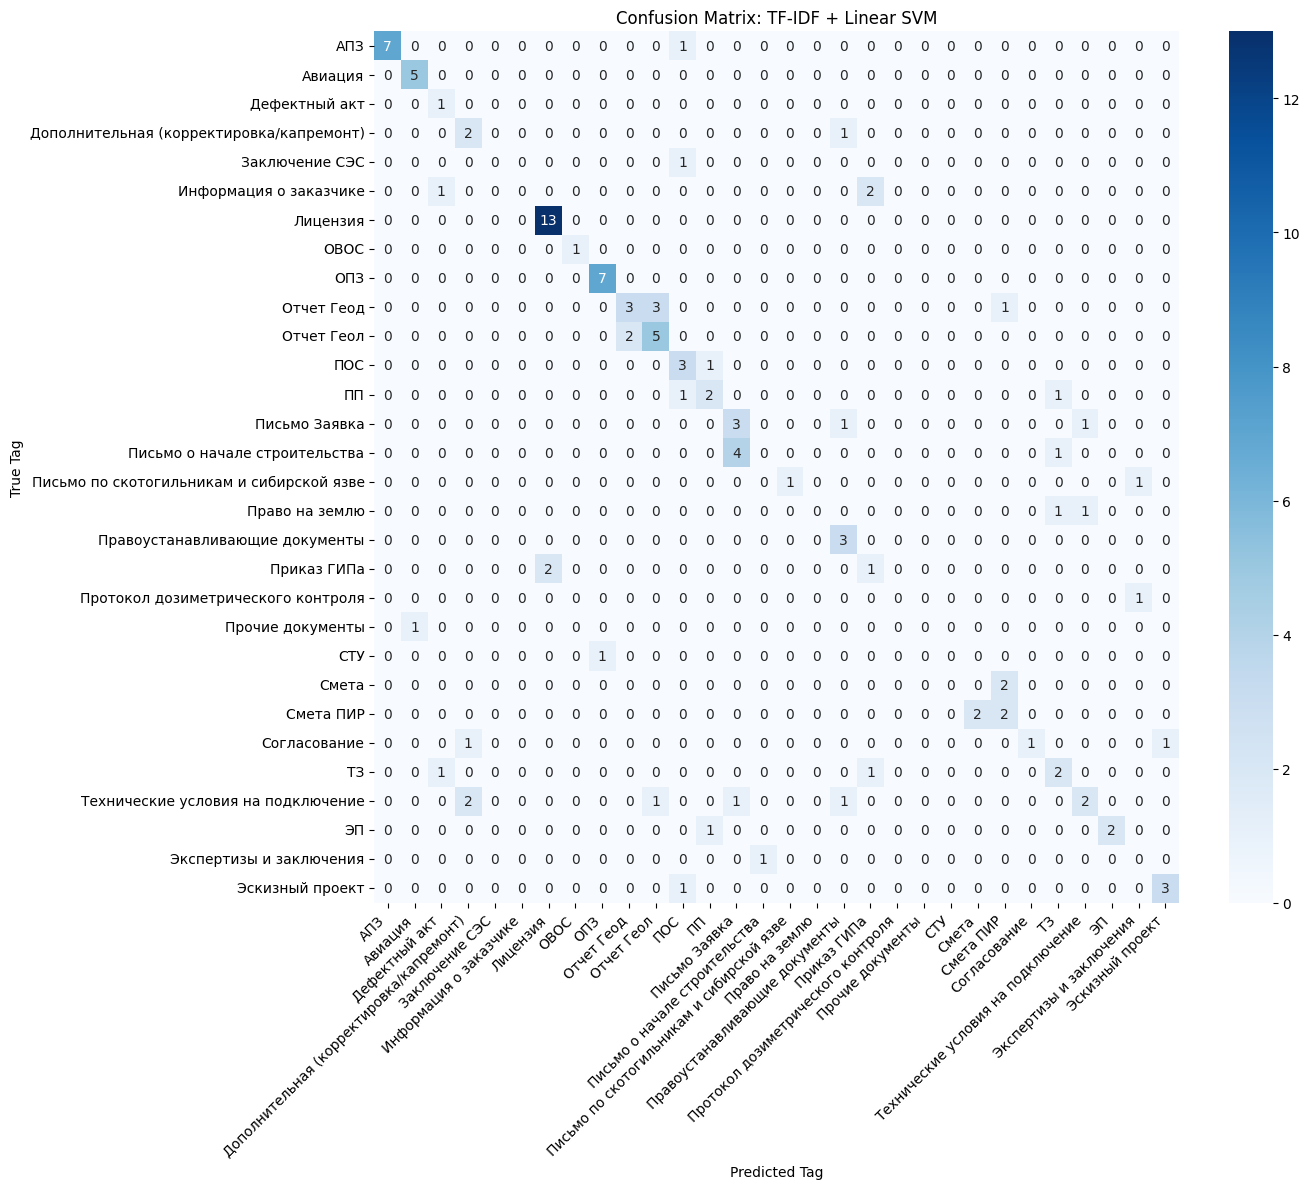

In [13]:
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, best_pred)
labels = sorted(list(set(y_test.tolist() + best_pred.tolist())))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix: TF-IDF + {best_model_name}')
plt.ylabel('True Tag')
plt.xlabel('Predicted Tag')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('tfidf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Keyword Importance Visualization

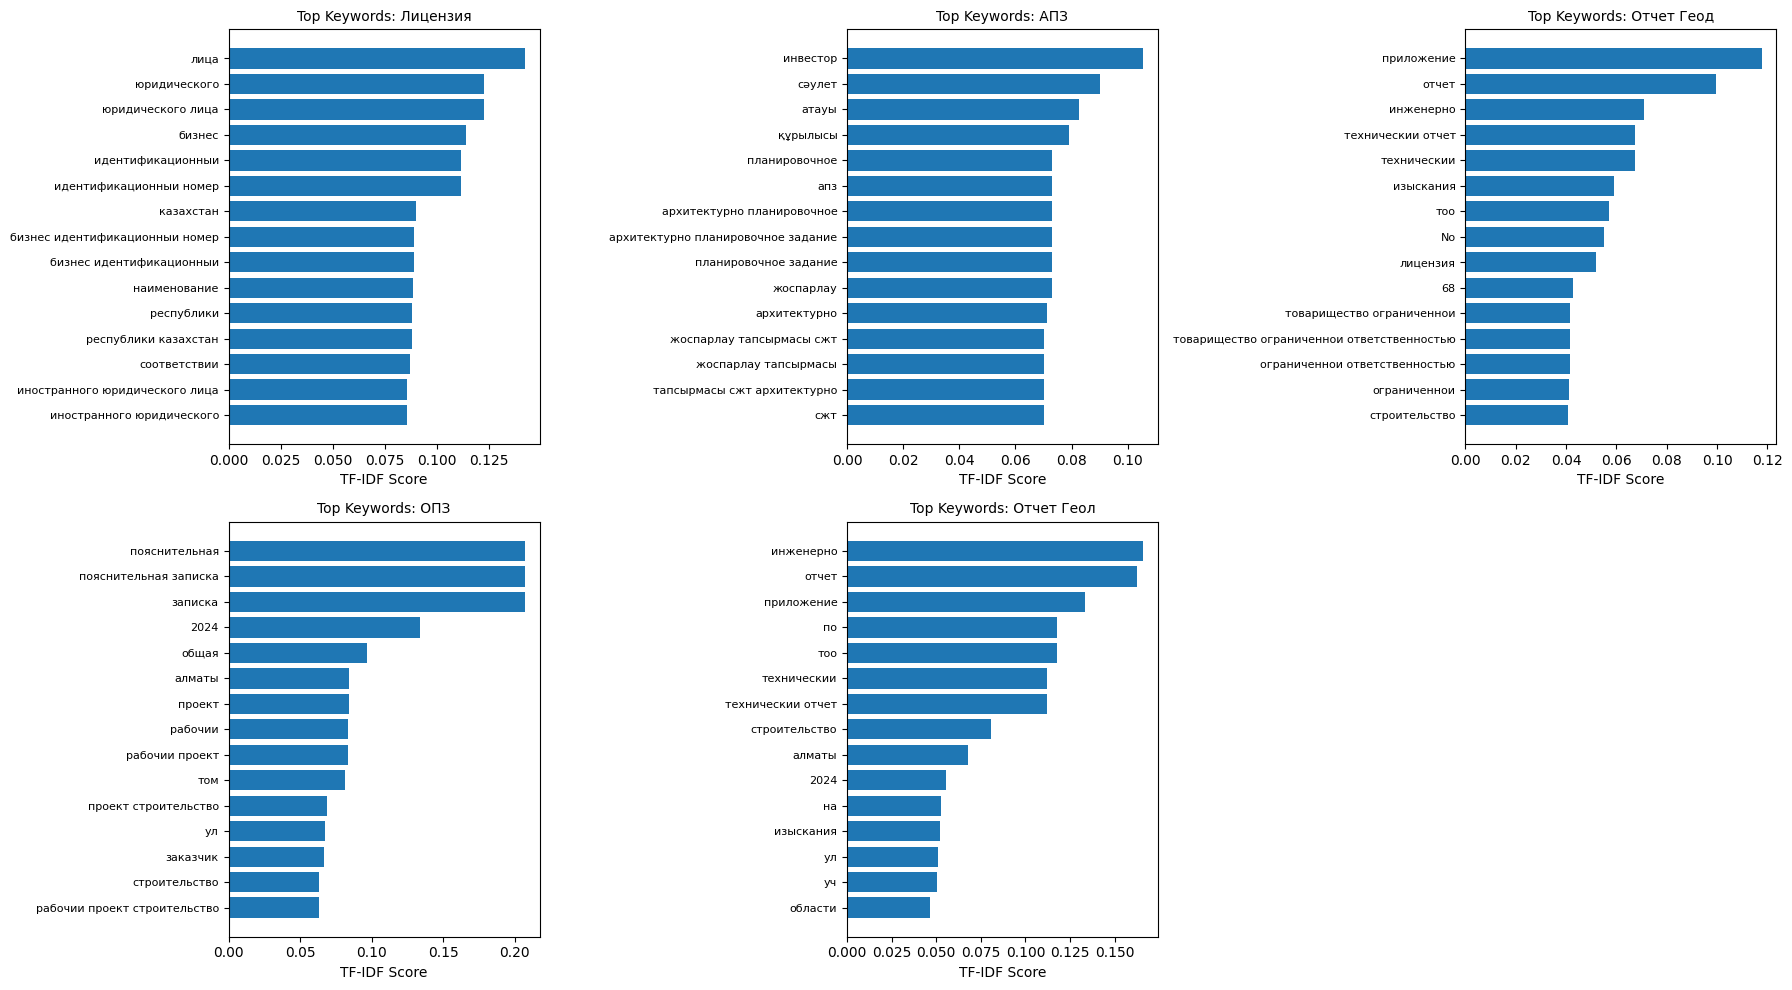

Keyword visualization saved!


In [14]:
# Visualize top keywords for top 5 classes
top_classes = train_df['primary_tag'].value_counts().head(5).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, tag in enumerate(top_classes):
    if idx >= len(axes):
        break
    
    keywords = class_keywords[tag][:15]
    words = [kw[0] for kw in keywords]
    scores = [kw[1] for kw in keywords]
    
    axes[idx].barh(range(len(words)), scores)
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words, fontsize=8)
    axes[idx].set_xlabel('TF-IDF Score')
    axes[idx].set_title(f'Top Keywords: {tag}', fontsize=10)
    axes[idx].invert_yaxis()

# Hide extra subplot
if len(top_classes) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('tfidf_top_keywords.png', dpi=300, bbox_inches='tight')
plt.show()

print("Keyword visualization saved!")

## 13. Save Model and Keywords

In [15]:
import joblib
import json

model_dir = './tfidf_models'
os.makedirs(model_dir, exist_ok=True)

# Save best model
models_map = {
    'Naive Bayes': nb_model,
    'Logistic Regression': lr_model,
    'Linear SVM': svm_model
}
best_model_obj = models_map[best_model_name]

joblib.dump(best_model_obj, f'{model_dir}/best_classifier.pkl')
joblib.dump(tfidf_vectorizer, f'{model_dir}/tfidf_vectorizer.pkl')

# Save keywords
keywords_serializable = {}
for tag, keywords in class_keywords.items():
    keywords_serializable[tag] = [(kw, float(score)) for kw, score in keywords]

with open(f'{model_dir}/class_keywords.json', 'w', encoding='utf-8') as f:
    json.dump(keywords_serializable, f, ensure_ascii=False, indent=2)

print(f"Model and keywords saved to {model_dir}/")

Model and keywords saved to ./tfidf_models/


## 14. Log to MLflow

In [ ]:
mlflow_recorder = MLflowRecorder(experiment_name=EXPERIMENT_NAME)

params = {
    "max_features": MAX_FEATURES,
    "ngram_range": str(NGRAM_RANGE),
    "train_size": len(train_df),
    "test_size": len(test_df),
    "num_classes": len(np.unique(y_train)),
    "best_model": best_model_name
}
mlflow_recorder.log_params(params)

metrics = {
    "nb_accuracy": nb_acc,
    "nb_f1": nb_f1,
    "lr_accuracy": lr_acc,
    "lr_f1": lr_f1,
    "svm_accuracy": svm_acc,
    "svm_f1": svm_f1,
    "best_accuracy": results_df['Accuracy'].max(),
    "best_f1": results_df['F1 Score'].max()
}
mlflow_recorder.log_metrics(metrics)

mlflow_recorder.log_artifact('tfidf_confusion_matrix.png')
mlflow_recorder.log_artifact('tfidf_top_keywords.png')

mlflow_recorder.set_tag("model_type", "tfidf_keywords")
mlflow_recorder.set_tag("best_classifier", best_model_name)

mlflow_recorder.end_run()
print("MLflow logging complete!")

## 15. Summary

In [ ]:
print("="*60)
print("EXPERIMENT SUMMARY: TF-IDF KEYWORDS")
print("="*60)
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"N-gram range: {NGRAM_RANGE}")
print(f"\nDataset:")
print(f"  Train: {len(train_df)} | Test: {len(test_df)}")
print(f"  Classes: {len(np.unique(y_train))}")
print(f"\nBest Model: {best_model_name}")
print(f"  Accuracy: {results_df.iloc[best_idx]['Accuracy']:.4f}")
print(f"  F1 Score: {results_df.iloc[best_idx]['F1 Score']:.4f}")
print(f"\nKeywords saved to: {model_dir}/class_keywords.json")
print("="*60)